In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix

from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models  import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
np.random.seed(0)
tf.random.set_seed(0)

In [3]:
df = pd.read_csv('../06-Sentiment-Analysis/AirlineTweets.csv')
df = df[['airline_sentiment','text']]
df = df[df['airline_sentiment'] != 'neutral'].copy()
df.head()

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


<AxesSubplot:>

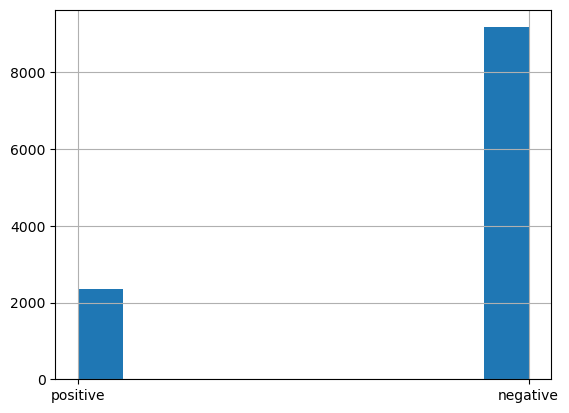

In [4]:
df['airline_sentiment'].hist()

In [5]:
target_map = {'negative' : 0, 'positive' : 1}
df['target'] = df['airline_sentiment'].map(target_map)
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [6]:
df_train,df_test = train_test_split(df,random_state=2000)

In [7]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test  = vectorizer.transform(df_test['text'])
y_train = df_train['target']
y_test  = df_test['target']

# input dimension
D = X_train.shape[1]

In [8]:
X_train = X_train.toarray()
X_test  = X_test.toarray()
# input dimension
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.24974196, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [9]:
i = Input(shape=(D,))
x = Dense(1)(i)
model = Model(i,x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(
    # sigmoid is applied otherwise the model has to apply sigmoid explicitely
    loss = BinaryCrossentropy(from_logits=True), 
    optimizer = Adam(learning_rate=0.01),
    metrics=['accuracy']
)

In [11]:
r = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=40,
    batch_size=128
)

Epoch 1/40
68/68 [==============================] - 3s 19ms/step - loss: 0.4999 - accuracy: 0.7961 - val_loss: 0.4103 - val_accuracy: 0.7928
Epoch 2/40
68/68 [==============================] - 1s 9ms/step - loss: 0.3711 - accuracy: 0.8009 - val_loss: 0.3529 - val_accuracy: 0.8049
Epoch 3/40
68/68 [==============================] - 1s 9ms/step - loss: 0.3181 - accuracy: 0.8208 - val_loss: 0.3151 - val_accuracy: 0.8330
Epoch 4/40
68/68 [==============================] - 1s 9ms/step - loss: 0.2810 - accuracy: 0.8466 - val_loss: 0.2896 - val_accuracy: 0.8472
Epoch 5/40
68/68 [==============================] - 1s 9ms/step - loss: 0.2540 - accuracy: 0.8662 - val_loss: 0.2709 - val_accuracy: 0.8642
Epoch 6/40
68/68 [==============================] - 1s 9ms/step - loss: 0.2334 - accuracy: 0.8839 - val_loss: 0.2571 - val_accuracy: 0.8753
Epoch 7/40
68/68 [==============================] - 1s 10ms/step - loss: 0.2171 - accuracy: 0.8954 - val_loss: 0.2464 - val_accuracy: 0.8836
Epoch 8/40
68/68 [

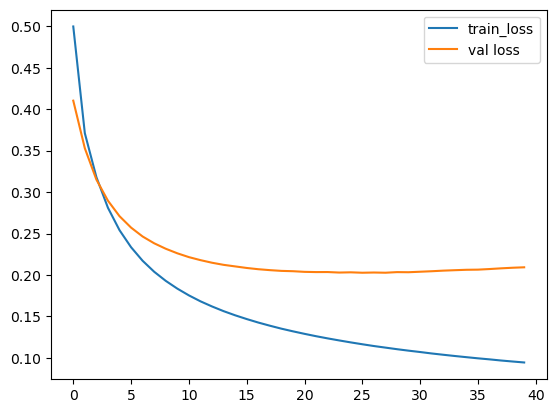

In [12]:
plt.plot(r.history['loss'],label='train_loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.legend()

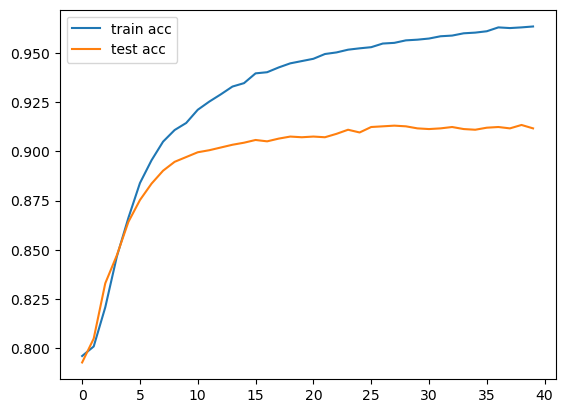

In [13]:
plt.plot(r.history['accuracy'],label='train acc')
plt.plot(r.history['val_accuracy'],label='test acc')
plt.legend()

In [14]:
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test  = ((model.predict(X_test) > 0)* 1.0).flatten()

91/91 [==============================] - 0s 4ms/step


In [15]:
cm = confusion_matrix(y_train,P_train)
cm

array([[6813,   77],
       [ 160, 1605]], dtype=int64)

In [16]:
def plot_cm(cm):
    classes = ['negative','positive']
    df_cm = pd.DataFrame(cm,index=classes,columns=classes)
    ax = sns.heatmap(df_cm,annot=True,fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

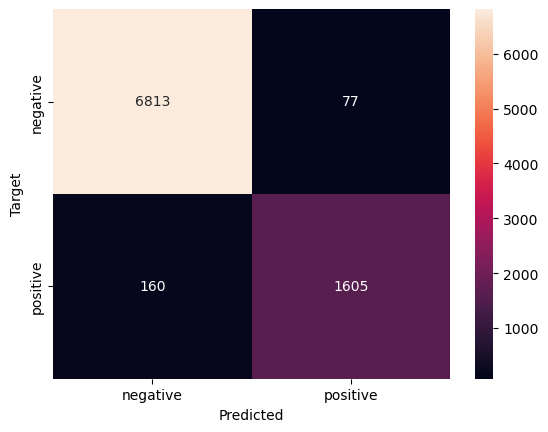

In [17]:
plot_cm(cm)

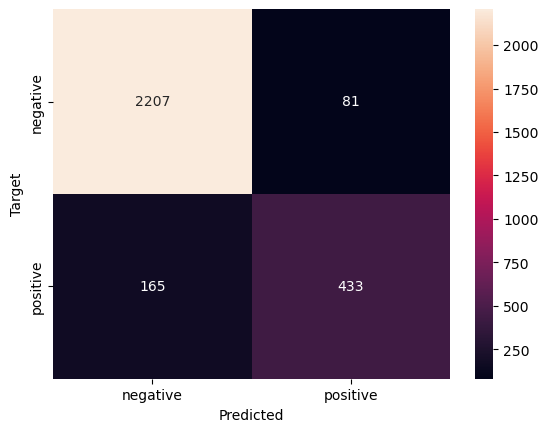

In [18]:
cm_test = confusion_matrix(y_test,P_test)
plot_cm(cm_test)

In [19]:
Pr_train = model.predict(X_train)
Pr_test  = model.predict(X_test)
print('Train AUC ', roc_auc_score(y_train,Pr_train))
print('Test AUC ', roc_auc_score(y_test,Pr_test))

91/91 [==============================] - 0s 4ms/step
Train AUC  0.9944394511896785
Test AUC  0.952746772458311


In [20]:
print('Train F1 ', f1_score(y_train,P_train))
print('Test F1 ', f1_score(y_test,P_test))

Train F1  0.9312445604873804
Test F1  0.7787769784172661


In [21]:
model.layers

In [22]:
model.layers[1].get_weights()

[array([[-3.3537395],
        [ 3.3597555],
        [-1.423935 ],
        ...,
        [-0.6760118],
        [-3.7872796],
        [-5.478839 ]], dtype=float32),
 array([-0.32196307], dtype=float32)]

In [23]:
w = model.layers[1].get_weights()[0]
word_index_map = vectorizer.vocabulary_
word_index_map

{'united': 1848,
 'thank': 1727,
 'you': 1994,
 'have': 853,
 'nice': 1207,
 'evening': 631,
 'americanair': 142,
 'next': 1205,
 'time': 1760,
 'my': 1186,
 'flight': 724,
 'cancelled': 309,
 'flightled': 731,
 'appreciate': 173,
 'some': 1612,
 'email': 605,
 'text': 1724,
 'carrier': 319,
 'app': 168,
 'didn': 533,
 'even': 630,
 'at': 196,
 'check': 349,
 'in': 934,
 'usairways': 1869,
 'doubt': 575,
 'it': 969,
 'gate': 795,
 'is': 964,
 'and': 147,
 'every': 634,
 'agent': 110,
 'saw': 1517,
 'including': 937,
 'one': 1250,
 'with': 1951,
 'me': 1114,
 'was': 1902,
 'rude': 1497,
 'just': 985,
 'very': 1882,
 'put': 1397,
 'off': 1233,
 'aa': 75,
 'this': 1744,
 'how': 903,
 'always': 137,
 'start': 1648,
 'http': 907,
 'co': 376,
 'crazy': 449,
 'haven': 854,
 'spoken': 1640,
 'to': 1768,
 'human': 910,
 'yet': 1991,
 'there': 1736,
 'has': 850,
 'be': 235,
 'better': 249,
 'way': 1912,
 'jetblue': 978,
 'also': 134,
 'thanks': 1729,
 'for': 753,
 'your': 1995,
 'prompt': 1386,


In [24]:
threshold = 2
print('Most positive words')
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index,0]
    if weight > threshold:
        word_weight_tuples.append((word,weight))

word_weight_tuples = sorted(word_weight_tuples,key=lambda x : -x[1])
for i in range(10):
    word,weight = word_weight_tuples[i]
    print(word,weight)

Most positive words
thank 9.448914
thanks 8.977468
great 7.446955
love 6.893299
worries 6.734719
awesome 6.6880555
kudos 6.5561256
excellent 6.461233
best 5.9610085
wonderful 5.9533434


In [25]:
threshold = 2
print('Most Negative words')
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index,0]
    if weight < -threshold:
        word_weight_tuples.append((word,weight))

word_weight_tuples = sorted(word_weight_tuples,key=lambda x : x[1])
for i in range(10):
    word,weight = word_weight_tuples[i]
    print(word,weight)

Most Negative words
worst -9.500019
hours -7.7535353
disappointed -7.3488684
paid -7.306198
rude -7.2812066
not -7.175875
pay -6.574268
money -6.446341
delayed -6.372104
worse -6.2555037
